<img src='resources/dl.jpg'>

# Sentiment Analysis with Keras

### Keras

Keras is a deep learning library that focuses on providing a high level neural network API that comes with the best practicises included. It's ideal for beginners until you need more advanced features or know why or why you wont need the various best practices.

### Sentiment Analysis

In [1]:
!apt-get install graphviz
!pip install graphviz pydot

E: Could not open lock file /var/lib/dpkg/lock - open (13: Permission denied)
E: Unable to lock the administration directory (/var/lib/dpkg/), are you root?


In [1]:
from IPython.display import SVG

import numpy as np
import string

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, LSTM, GRU, Bidirectional, Conv1D, GlobalMaxPooling1D
from keras.datasets import imdb
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


## IMDB Movie reviews sentiment classification

Dataset of 25,000 movies reviews from IMDB, labeled by sentiment (positive/negative). Reviews have been preprocessed, and each review is encoded as a sequence of word indexes (integers). 

For convenience, words are indexed by overall frequency in the dataset, so that for instance the integer "3" encodes the 3rd most frequent word in the data. This allows for quick filtering operations such as: "only consider the top 10,000 most common words, but eliminate the top 20 most common words", by using the ```num_words``` argument.

As a convention, "0" does not stand for a specific word, but instead is used to encode any unknown word.

In [53]:
number_of_words_tokenised = 20000
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=number_of_words_tokenised,
                                                      index_from=3)

In [54]:
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

25000 train sequences
25000 test sequences


In [55]:
print('Pad sequences (samples x time)')
# cut texts after this number of words
# (among top max_features most common words)
maxlen = 100
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
y_train = np.array(y_train)
y_test = np.array(y_test)

Pad sequences (samples x time)
x_train shape: (25000, 100)
x_test shape: (25000, 100)


## Understanding the dataset

Here we go from sequences of embedding indices to sentances and back again.

In [5]:
def convert_sentance_to_indices(sentance, 
                                max_sentance_length,
                                word_to_index_dict, 
                                start_index=1, 
                                unknown_index=2,
                                pad_index=0,
                                remove_punctuation=False):
    
    if remove_punctuation:
        strip_table = str.maketrans({key: None for key in string.punctuation})
        sentance = sentance.translate(strip_table)
        
    indices = [start_index]
    for word_count, word in enumerate(sentance.split()):
        
        if word_count >= max_sentance_length:
            break
            
        try:
            index = word_to_index_dict[word]
        except:
            index = unknown_index
        indices.append(index)
        
    while len(indices) < max_sentance_length:
        indices = [pad_index] + indices
    
    return indices


def convert_indices_to_sentance(indices, index_to_word_dict):
    words = [index_to_word_dict[index] for index in indices]
    return " ".join(words)

In [6]:
word_to_index_dict = imdb.get_word_index()
word_to_index_dict = {key: (value + 3) for key, value in word_to_index_dict.items()}
word_to_index_dict['<START>'] = 1
word_to_index_dict['<PAD>'] = 0
word_to_index_dict['<UNKNOWN>'] = 2

index_to_word_dict = {value: key for key, value in word_to_index_dict.items()}

In [7]:
index = 100

sentance = convert_indices_to_sentance(x_test[index], index_to_word_dict)
label = y_test[index]

print("\n** What the neural network will see: **")
print(x_test[index])

print("\n** What we humans like to see: **")
print(sentance)

print("\n** What we want the neural network to predict: **")
print(label)

print("\n** The label is: **")
print("Positive" if label == 1 else "Negative")


** What the neural network will see: **
[    0     0     0     0     0     0     0     0     0     0     1    14
    22     9  1329     8    30     6   147  7942   894    25   391     4
  2331   467    63    12    16    93     4    71  2218     8    30   177
    11     4    22   310     7     6   297    15    16    24  1822   398
    18    98    36    26   432     7  1147 16756    83     4   555  3614
    12   238    28    77  2805    48    12    69   343   275   156    37
   122    24    28   141   312  1398  2611   725    98   305    12    47
    77  1437     2    17   173     7     6 10070     8    63    12    66
   152  1833     8  4881]

** What we humans like to see: **
<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <START> this film is likely to be a real letdown unless you understand the circumstances under which it was made the were chosen to be cast in the film version of a play that was not originally written for them they are sort of force fitted into the role

## Making models is like playing with Lego


Keras allows us to play with neural architecture lego blocks and stack things together in weird and wonderful ways. For now don't get bogged down in the theory of what works and doesn't work. Just be aware of what the shape each block needs as an input, and what the shape each block will output.

<img src="resources/tower.jpg" width="400">

Below are a bunch of models that you can try and extend, aswell as a blank function you could fill in with your own creation! [Feel free to browse the reference for available neural lego blocks to use.](https://keras.io/layers/about-keras-layers/)

In [8]:
def rnn(number_of_words_tokenised, rnn_type='lstm', hidden_size=64, keep_prob=0.5):
    
    model = Sequential()
    model.add(Embedding(number_of_words_tokenised, 128))
    
    if rnn_type is 'lstm':
        rnn_cell = LSTM(hidden_size, dropout=keep_prob, recurrent_dropout=keep_prob)
    else:
        rnn_cell = GRU(hidden_size, dropout=keep_prob, recurrent_dropout=keep_prob)
        
    model.add(rnn_cell)
    model.add(Dense(1, activation='sigmoid'))
    
    return model


def bidirectional_rnn(number_of_words_tokenised, rnn_type='lstm', hidden_size=64, keep_prob=0.5):
    
    model = Sequential()
    
    model.add(Embedding(number_of_words_tokenised, 128, input_length=maxlen))
    
    rnn_cell = LSTM(hidden_size) if rnn_type is 'lstm' else GRU(hidden_size)
    
    model.add(Bidirectional(rnn_cell))
    model.add(Dropout(keep_prob))
    model.add(Dense(1, activation='sigmoid'))
    
    return model


def convolutional(number_of_words_tokenised, filters = 250, kernel_size = 3, hidden_dims=250, keep_prob=0.2):
    
    model = Sequential()

    # we start off with an efficient embedding layer which maps
    # our vocab indices into embedding_dims dimensions
    model.add(Embedding(number_of_words_tokenised, 128, input_length=maxlen))
    model.add(Dropout(keep_prob))

    # we add a Convolution1D, which will learn filters
    # word group filters of size filter_length:
    model.add(Conv1D(filters,
                     kernel_size,
                     padding='valid',
                     activation='relu',
                     strides=1))
    # we use max pooling:
    model.add(GlobalMaxPooling1D())

    # We add a vanilla hidden layer:
    model.add(Dense(hidden_dims))
    model.add(Dropout(keep_prob))
    model.add(Activation('relu'))

    # We project onto a single unit output layer, and squash it with a sigmoid:
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    return model


def my_model(number_of_words_tokenised):
    
    model = Sequential()
    
    # ... Insert code here ...
    # Ensure that the model ends with a single
    # sigmoidal unit.
    
    return model

## Construct desired model and view structure

We choose the function we would like to construct our model and we then run it through a few helper functions to visualise the graph.

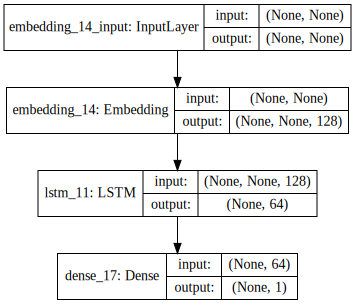

In [44]:
model = rnn(number_of_words_tokenised)
# model = bidirectional_rnn(number_of_words_tokenised)
# model = convolutional(number_of_words_tokenised)
# model = my_model(number_of_words_tokenised)

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## Training

In [45]:
# try using different optimizers and different optimizer configs
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

In [46]:
batch_size = 32
epochs = 4

model.fit(x_train, 
          y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=[x_test, y_test])

Train on 25000 samples, validate on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 96s - loss: 0.5163 - acc: 0.7416 - val_loss: 0.4198 - val_acc: 0.8076
Epoch 2/4
25000/25000 [==============================] - 91s - loss: 0.3822 - acc: 0.8361 - val_loss: 0.3935 - val_acc: 0.8288
Epoch 3/4
25000/25000 [==============================] - 91s - loss: 0.3097 - acc: 0.8726 - val_loss: 0.3957 - val_acc: 0.8306
Epoch 4/4
25000/25000 [==============================] - 96s - loss: 0.2570 - acc: 0.8988 - val_loss: 0.4216 - val_acc: 0.8363


## Using the model!

The first step is to create a bunch of sentances that are either positive or negative. The model will then predict this. Because the model ends with a single sigmoidal neuron, which means the value it will output will be squashed between zero and one, we can simply binarise the value by checking if it is greater than 0.5.

In [52]:
test_sentances = []

test_sentances.append("good movie")
test_sentances.append("bad movie")
test_sentances.append("I hate big corporations, especially tech companies like facebook.")
test_sentances.append("I love being a contrarian.")
test_sentances.append("Argh! Fuck this!")
test_sentances.append("To be honest this was a fun thing.")
test_sentances.append("Just tried watching Modern Family - written by a moron, really boring. Writer has the mind of a very dumb and backward child.")
test_sentances.append("I look very much forward to showing my financials, because they are huge.")

for i, test_sentance in enumerate(test_sentances):
    
    test_sentance_indices = convert_sentance_to_indices(test_sentance, 
                                                        maxlen, 
                                                        word_to_index_dict)
    test_sentance_indices = np.array(test_sentance_indices).reshape((1, -1))

    prediction = model.predict(x=test_sentance_indices)[0]

    if prediction < 0.5:
        print("{}. '{}' was a negative sentance".format(i, test_sentance))
    else:
        print("{}. '{}' was a positive sentance".format(i, test_sentance))

0. 'good movie' was a positive sentance
1. 'bad movie' was a negative sentance
2. 'I hate big corporations, especially tech companies like facebook.' was a negative sentance
3. 'I love being a contrarian.' was a positive sentance
4. 'Argh! Fuck this!' was a negative sentance
5. 'To be honest this was a fun thing.' was a positive sentance
6. 'Just tried watching Modern Family - written by a moron, really boring. Writer has the mind of a very dumb and backward child.' was a negative sentance
7. 'I look very much forward to showing my financials, because they are huge.' was a positive sentance
